# 🐍 Machine Learning Project Script

In [3]:
import pandas as pd
import ast
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

# 1. Upload data

In [4]:
df_train_raw = pd.read_csv("train.csv", sep=',')
df_train_raw["edgelist"].head(1)
df_train_raw["edgelist"] = df_train_raw["edgelist"].apply(ast.literal_eval)

df_test_raw = pd.read_csv("test.csv", sep=',')
df_test_raw["edgelist"].head(1)
df_test_raw["edgelist"] = df_test_raw["edgelist"].apply(ast.literal_eval)

# 2. Pre-Processing


In [16]:
import networkx as nx
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from itertools import combinations
from community import community_louvain  # pip install python-louvain

def normalize_group(df_group):
    numeric_cols = [
        'degree', 'closeness', 'betweenness', 'pagerank',
        'eigenvector', 'katz', 'load',
        'eccentricity', 'avg_neighbor_degree',
         'community', 'is_leaf'
        #'shortest_path_length', 'is_leaf', 'neighbor_connectivity'
    ]
    scaler = MinMaxScaler()
    df_group[numeric_cols] = scaler.fit_transform(df_group[numeric_cols])
    return df_group

def pre_processing(data):
    training_data = []

    for idx, row in data.iterrows():
        edgelist = row["edgelist"]
        
        # Create undirected graph
        T = nx.Graph()
        T.add_edges_from(edgelist)

        if not nx.is_connected(T):
            continue
        
        root_node = row.get("root", None)
        
        # Compute centralities
        closeness = nx.closeness_centrality(T)
        betweenness = nx.betweenness_centrality(T)
        pagerank = nx.pagerank(T, max_iter=1000)
        
        # Additional centrality measures with fallbacks
        try:
            eigenvector = nx.eigenvector_centrality(T, max_iter=10000, tol=1e-06)
        except nx.PowerIterationFailedConvergence:
            eigenvector = {n: 0.0 for n in T.nodes}
            
        try:
            katz = nx.katz_centrality(T, alpha=0.1)
        except nx.NetworkXException:
            katz = {n: 0.0 for n in T.nodes}
            
        try:
            load = nx.load_centrality(T)
        except:
            load = {n: 0.0 for n in T.nodes}

        # Structural properties
        degree = dict(T.degree())
        eccentricity = nx.eccentricity(T)
        avg_neighbor_degree = nx.average_neighbor_degree(T)
        
        # Community detection
        partition = community_louvain.best_partition(T)
        
        for v in T.nodes:
            # Base features
            base_features = {
                "sentence": row["sentence"],
                "language": row["language"],
                "n": row["n"],
                "node": v,

                # Centrality measures
                "degree": degree[v],
                "closeness": closeness[v],
                "betweenness": betweenness[v],
                "pagerank": pagerank[v],
                "eigenvector": eigenvector[v],
                "katz": katz[v],
                "load": load[v],

                # Structural properties
                "eccentricity": eccentricity[v],
                "avg_neighbor_degree": avg_neighbor_degree[v],

                # Community information
                "community": partition[v],

                "is_leaf": 1 if T.degree(v) == 1 else 0,
            }

            # Calculate interaction features
            interaction_features = {
                # Multiplicative interactions
                "community_betweenness": base_features["community"] * base_features["betweenness"],
                "eigenvector_closeness": base_features["eigenvector"] * base_features["closeness"],
                "katz_pagerank": base_features["katz"] * base_features["pagerank"],
                
                # Additive interactions
                "betweenness_plus_eigenvector": base_features["betweenness"] + base_features["eigenvector"],
                
                # Ratio features
                "degree_ratio": base_features["degree"] / max(1, base_features["n"]),
                "betweenness_norm": base_features["betweenness"] / max(1, (base_features["n"] - 1)),
                
                # Difference features
                "closeness_minus_betweenness": base_features["closeness"] - base_features["betweenness"],
            }

            # Combine all features
            features = {**base_features, **interaction_features}

            if "id" in row:
                features["id"] = row["id"]

            if root_node is not None:
                features["is_root"] = 1 if v == root_node else 0

            training_data.append(features)

    training_data = pd.DataFrame(training_data)
    
    # Normalize features by group
    df_normalized = training_data.groupby(["sentence", "language"], group_keys=True).apply(
        normalize_group, include_groups=False
    )
    df_normalized.reset_index(inplace=True)
    df_normalized.drop(columns=["level_2"], inplace=True)

    return df_normalized

In [15]:
df_train = pre_processing(df_train_raw)

df_train

,sentence,language,n,node,degree,closeness,betweenness,pagerank,eigenvector,katz,...,community,is_leaf,community_betweenness,eigenvector_closeness,katz_pagerank,betweenness_plus_eigenvector,degree_ratio,betweenness_norm,closeness_minus_betweenness,is_root
0,2,Arabic,21,10,1.00,0.730183,0.724771,0.932971,0.990346,0.996388,...,0.666667,0.0,0.831579,0.098610,0.017127,0.874326,0.142857,0.020789,-0.200736,1
1,2,Arabic,21,8,1.00,0.908084,0.990826,0.891309,1.000000,1.000000,...,0.333333,0.0,0.568421,0.110227,0.016666,1.031373,0.142857,0.028421,-0.330326,0
2,2,Arabic,21,5,0.50,0.598665,0.174312,0.518343,0.547862,0.477072,...,0.333333,0.0,0.100000,0.050728,0.011178,0.356174,0.095238,0.005000,0.098020,0
3,2,Arabic,21,13,0.00,0.356589,0.000000,0.042182,0.236520,0.004953,...,0.333333,1.0,0.000000,0.018964,0.005677,0.113787,0.047619,0.000000,0.166667,0
4,2,Arabic,21,6,0.50,0.976170,0.908257,0.415764,0.703950,0.567473,...,0.333333,0.0,0.521053,0.080879,0.010327,0.848611,0.095238,0.026053,-0.274139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197474,995,Turkish,16,14,0.25,0.356543,0.200000,0.277926,0.417002,0.302740,...,0.500000,0.0,0.133333,0.073214,0.017342,0.372499,0.125000,0.008889,0.172789,0
197475,995,Turkish,16,10,0.00,0.061625,0.000000,0.029047,0.103774,0.004653,...,0.500000,1.0,0.000000,0.022602,0.008613,0.094929,0.062500,0.000000,0.238095,0
197476,995,Turkish,16,2,0.50,1.000000,0.885714,0.467346,0.842910,0.614483,...,0.000000,0.0,0.000000,0.197859,0.025924,1.025766,0.187500,0.039365,-0.135931,0
197477,995,Turkish,16,1,0.00,0.304498,0.000000,0.007093,0.335177,0.074379,...,0.500000,1.0,0.000000,0.059261,0.008264,0.201487,0.062500,0.000000,0.294118,0


# 3. Models

**K-Fold Cross Validation**

In [32]:
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone

def enhanced_training_pipeline(df, features, n_folds=10):
    """Enhanced training pipeline with calibration and improved regularization"""
    # Create group identifiers
    df['group_id'] = df["sentence"].astype(str) + '_' + df["language"]
    X = df[features]
    y = df['is_root']
    groups = df["group_id"]
    
    # Calculate class weights for imbalance handling
    class_ratio = len(y[y==0]) / len(y[y==1]) if len(y[y==1]) > 0 else 1
    
    # Initialize models with enhanced regularization
    models = {
        "Random Forest": RandomForestClassifier(
            max_depth=8,
            min_samples_split=15,
            min_samples_leaf=5,
            n_estimators=200,
            class_weight='balanced_subsample',
            max_features=0.33,
            max_samples=0.8,
            min_impurity_decrease=0.001,
            ccp_alpha=0.01,
            random_state=42,
            n_jobs=-1
        ),
        "XGB Classifier": XGBClassifier(
            max_depth=3,  # Reduced from 4
            learning_rate=0.01,  # Reduced from 0.03
            subsample=0.65,  # Reduced from 0.8
            colsample_bytree=0.6,  # Reduced from 0.8
            colsample_bylevel=0.6,  # Reduced from 0.8
            colsample_bynode=0.6,  # Reduced from 0.8
            n_estimators=1200,  # Increased from 500
            reg_alpha=1.5,  # Increased from 0.5
            reg_lambda=2.0,  # Increased from 1.0
            gamma=0.3,  # Increased from 0.1
            min_child_weight=5,  # Increased from 3
            grow_policy='lossguide',  # Changed from 'depthwise'
            eval_metric='logloss',
            random_state=42,
            early_stopping_rounds=20,
            tree_method='hist',
            n_jobs=-1
        )
    }
    
    results = {}
    feature_importances = pd.DataFrame(index=features)
    oof_predictions = pd.DataFrame(index=df.index, columns=list(models.keys()))
    oof_probabilities = pd.DataFrame(index=df.index, columns=list(models.keys()))
    
    for model_name, model in models.items():
        print(f"\n=== Evaluating {model_name} ===")
        metrics = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}
        
        cv = StratifiedGroupKFold(n_splits=n_folds)
        
        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=groups)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Ensure no group overlap
            assert len(set(groups.iloc[train_idx]) & set(groups.iloc[val_idx])) == 0
            
            # Feature selection per fold
            selector = SelectFromModel(
                RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    min_samples_split=5,
                    random_state=42
                ),
                threshold="median"
            )
            selector.fit(X_train, y_train)
            X_train_fs = selector.transform(X_train)
            X_val_fs = selector.transform(X_val)
            
            # Track feature importance
            if hasattr(selector.estimator_, 'feature_importances_'):
                feature_importances[f'{model_name}_fold_{fold}'] = selector.estimator_.feature_importances_
            
            # Fit model
            if model_name == "XGB Classifier":
                model.fit(
                    X_train_fs, y_train,
                    eval_set=[(X_val_fs, y_val)],
                    verbose=False
                )
            else:
                model.fit(X_train_fs, y_train)
            
            # Evaluate
            y_pred = model.predict(X_val_fs)
            report = classification_report(y_val, y_pred, output_dict=True)
            for metric in metrics:
                metrics[metric].append(report['weighted avg'][metric])
            
            oof_predictions.loc[val_idx, model_name] = y_pred
            if hasattr(model, 'predict_proba'):
                oof_probabilities.loc[val_idx, model_name] = model.predict_proba(X_val_fs)[:, 1]
        
        # Store results
        results[model_name] = {
            metric: np.mean(values) for metric, values in metrics.items()
        }
        
        print(f"\nSimple Evaluation:")
        print(f"Precision: {results[model_name]['precision']:.4f}")
        print(f"Recall:    {results[model_name]['recall']:.4f}")
        print(f"F1 Score:  {results[model_name]['f1-score']:.4f}")
    
    # Feature importance analysis
    for model_name in models:
        model_cols = [col for col in feature_importances.columns if model_name in col]
        if model_cols:
            feature_importances[f'{model_name}_mean'] = feature_importances[model_cols].mean(axis=1)
            feature_importances[f'{model_name}_std'] = feature_importances[model_cols].std(axis=1)
    
    print("\nFeature Importance Analysis:")
    print(feature_importances.nlargest(10, [col for col in feature_importances.columns if 'mean' in col][0]))
    
    # Select stable features and train final model
    best_model_name = max(results.items(), key=lambda x: x[1]['f1-score'])[0]
    stable_features = feature_importances.nlargest(
        int(len(features)*0.50),
        f'{best_model_name}_mean'
    ).index
    
    print(f"\nBest model: {best_model_name}")
    print(f"Selected {len(stable_features)} stable features for final model")
    
    X_fs = X[stable_features]
    best_model = models[best_model_name]
    
    if best_model_name == "XGB Classifier":
        X_train, X_val, y_train, y_val = train_test_split(
            X_fs, y, test_size=0.2, stratify=y, random_state=42
        )
        best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    else:
        best_model.fit(X_fs, y)
    
    # Add probability calibration
    # Create a copy of the model without early stopping for calibration
    calibration_model = clone(best_model)
    if hasattr(calibration_model, 'early_stopping_rounds'):
        calibration_model.set_params(early_stopping_rounds=None)

    calibrated_model = CalibratedClassifierCV(
        calibration_model,
        cv=5,
        method='isotonic'
    )
    calibrated_model.fit(X_fs, y)
    
    return {
        'results': results,
        'best_model_name': best_model_name,
        'best_model': best_model,
        'calibrated_model': calibrated_model,
        'stable_features': stable_features,
        'feature_importances': feature_importances,
        'oof_predictions': oof_predictions,
        'oof_probabilities': oof_probabilities
    }


In [33]:
# === Implementation ===
features = [col for col in df_train.columns if col not in ['id', 'sentence', 'language', 'is_root', 'group_id']]
pipeline_results = enhanced_training_pipeline(df_train, features)


=== Evaluating Random Forest ===

Simple Evaluation:
Precision: 0.9419
Recall:    0.7407
F1 Score:  0.8118

=== Evaluating XGB Classifier ===

Simple Evaluation:
Precision: 0.9309
Recall:    0.9480
F1 Score:  0.9289

Feature Importance Analysis:
                              Random Forest_fold_0  Random Forest_fold_1  \
betweenness_plus_eigenvector              0.137661              0.138453   
community                                 0.123111              0.108973   
community_betweenness                     0.101832              0.117799   
eigenvector_closeness                     0.084672              0.085093   
betweenness_norm                          0.069731              0.076667   
eigenvector                               0.068645              0.059676   
katz                                      0.063689              0.061746   
degree_ratio                              0.049074              0.050037   
load                                      0.046785              0.044

In [34]:
def predict_on_test(test_df, pipeline_results, confidence_threshold=0.6):
    """
    Predict one root node per group (`id`) using calibrated probabilities.

    - Blends calibrated and raw model probabilities
    - Applies threshold, but always guarantees one prediction per group
    """
    X_test = test_df[pipeline_results['stable_features']]

    # Predict probabilities
    raw_proba = pipeline_results['best_model'].predict_proba(X_test)[:, 1]
    calib_proba = pipeline_results['calibrated_model'].predict_proba(X_test)[:, 1]

    # Blend probabilities
    test_df['pred_proba'] = 0.7 * calib_proba + 0.3 * raw_proba
    test_df['pred_root'] = (test_df['pred_proba'] >= confidence_threshold).astype(int)

    # Guarantee one prediction per group (`id`)
    def select_root(group):
        confident = group[group['pred_root'] == 1]
        if not confident.empty:
            return confident.loc[confident['pred_proba'].idxmax()]
        else:
            return group.loc[group['pred_proba'].idxmax()]

    predicted_roots = test_df.groupby('id').apply(select_root).reset_index(drop=True)

    return predicted_roots[['id', 'node']].rename(columns={'node': 'root'}).sort_values('id').reset_index(drop=True)


# Process test data and make predictions with confidence thresholding
df_test_processed = pre_processing(df_test_raw.copy())
output_df = predict_on_test(df_test_processed, pipeline_results, confidence_threshold=0.6)
output_df.to_csv('predicted_roots.csv', index=False)
print("Predictions saved to predicted_roots.csv")

# Optional: Threshold tuning if you have labeled test data
if 'is_root' in df_test_processed.columns:
    print("\nThreshold Tuning Results:")
    for threshold in [0.5, 0.55, 0.6, 0.65, 0.7]:
        temp_preds = predict_on_test(df_test_processed, pipeline_results, threshold)
        print(f"\nThreshold {threshold}:")
        print(classification_report(df_test_processed.groupby('id')['is_root'].first(), 
                                  temp_preds.set_index('id')['root']))

Predictions saved to predicted_roots.csv


/tmp/ipykernel_165682/721075582.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  predicted_roots = test_df.groupby('id').apply(select_root).reset_index(drop=True)


Train stats:
                   n           node         degree      closeness  \
count  197479.000000  197479.000000  197479.000000  197479.000000   
mean       22.374151      11.687076       0.287784       0.434823   
std         8.959233       8.269808       0.315252       0.288651   
min         3.000000       1.000000       0.000000       0.000000   
25%        16.000000       5.000000       0.000000       0.207285   
50%        21.000000      10.000000       0.250000       0.399371   
75%        27.000000      16.000000       0.500000       0.624026   
max        70.000000      70.000000       1.000000       1.000000   

         betweenness       pagerank    eigenvector           katz  \
count  197479.000000  197479.000000  197479.000000  197479.000000   
mean        0.281812       0.303808       0.310768       0.305130   
std         0.329703       0.303504       0.279512       0.301167   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000

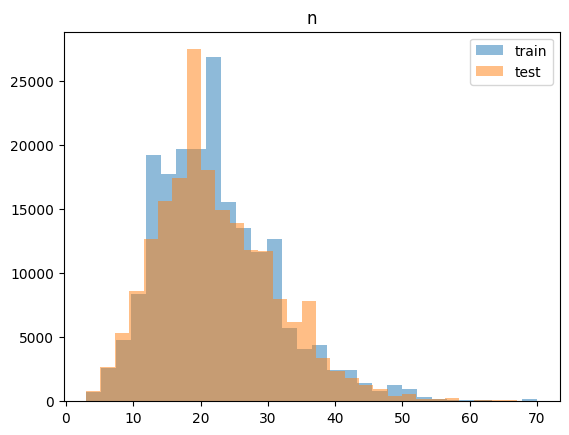

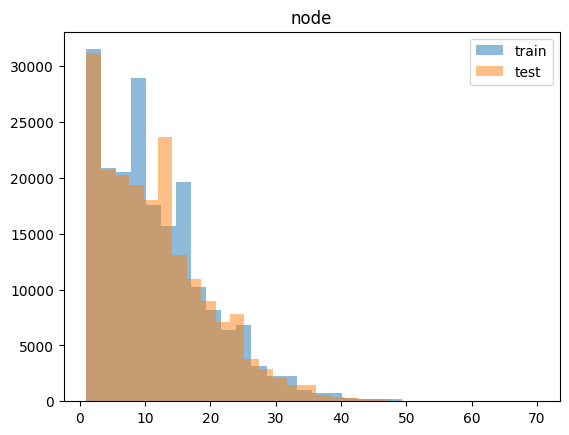

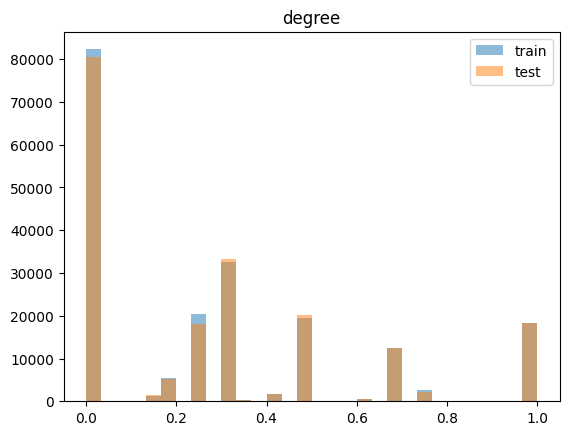

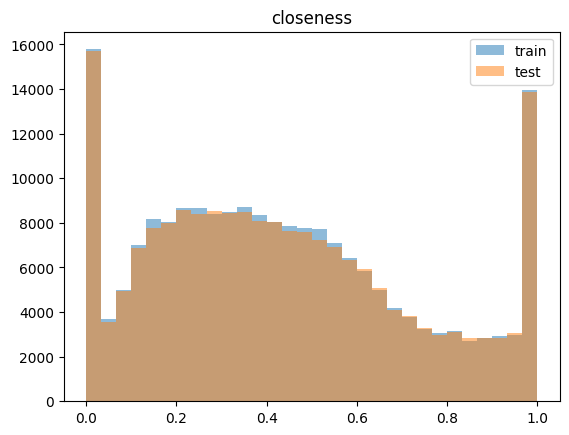

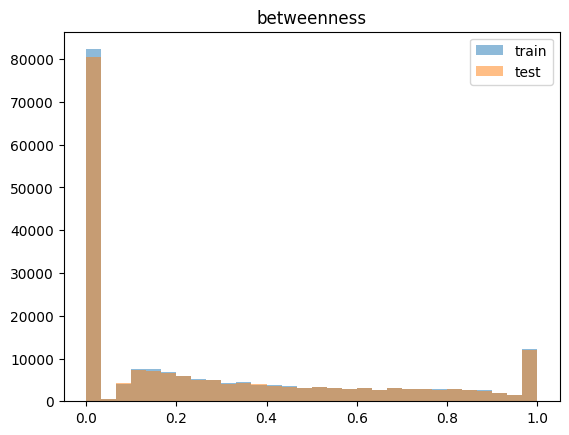

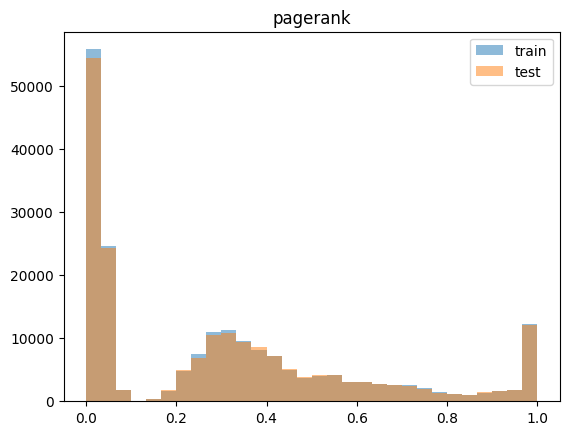

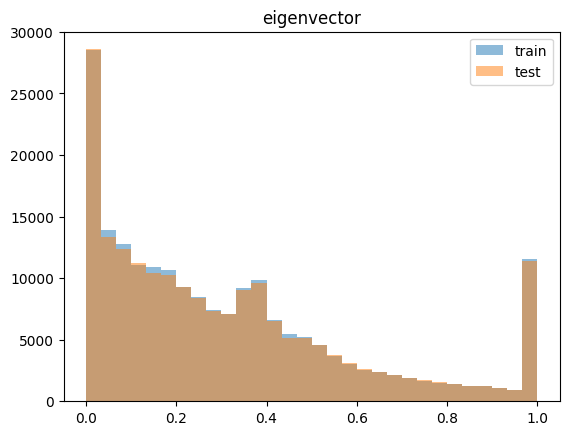

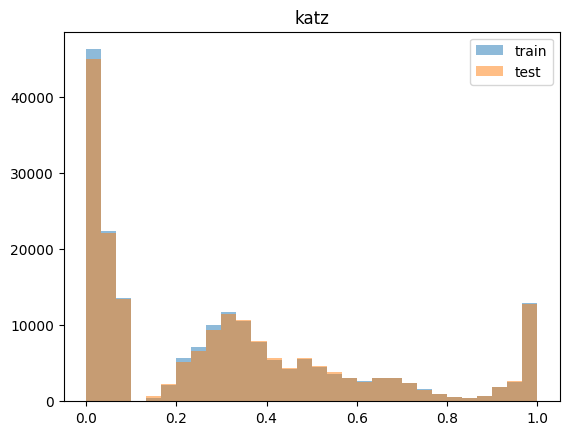

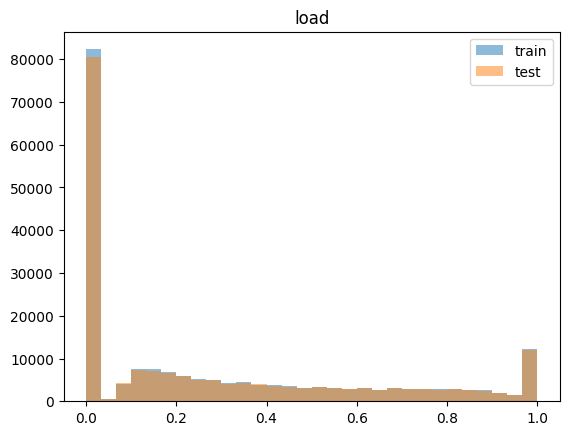

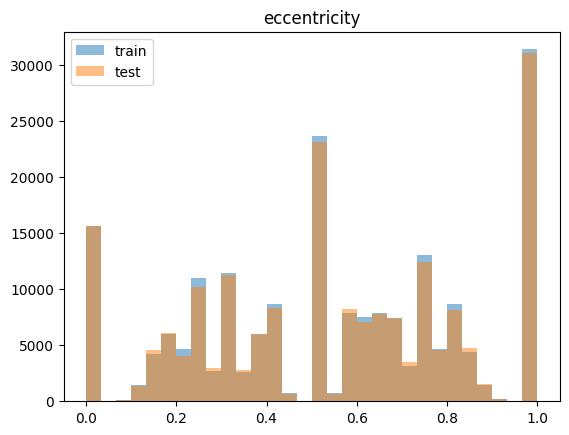

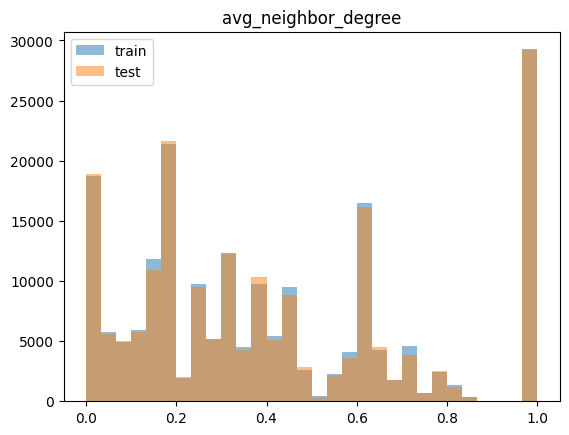

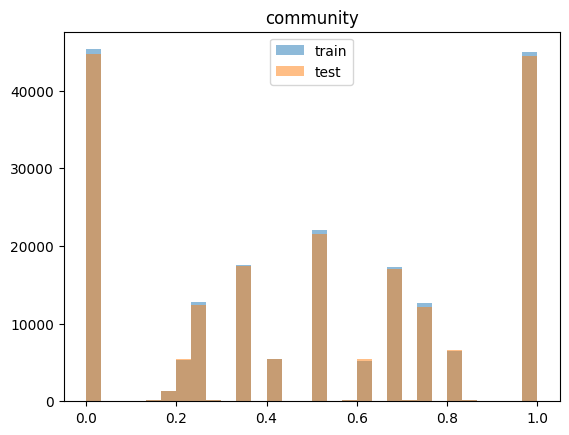

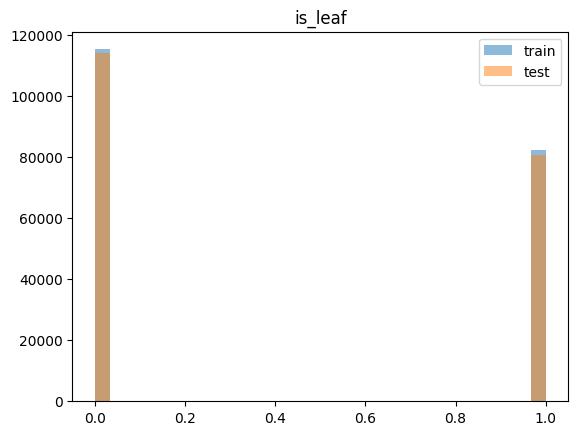

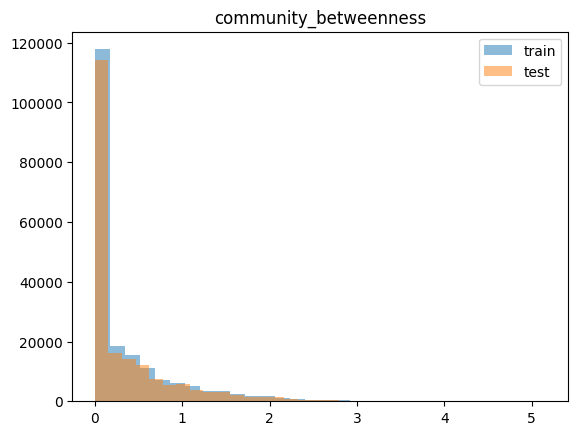

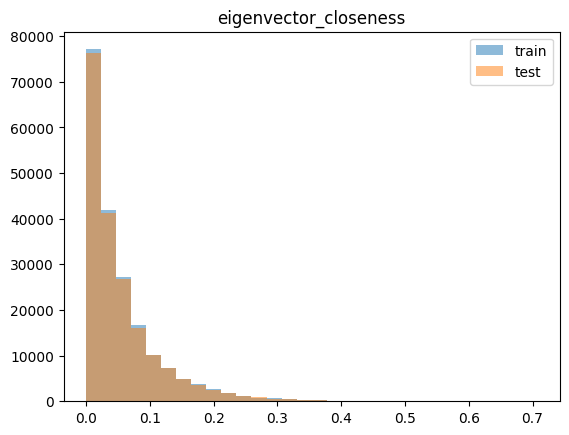

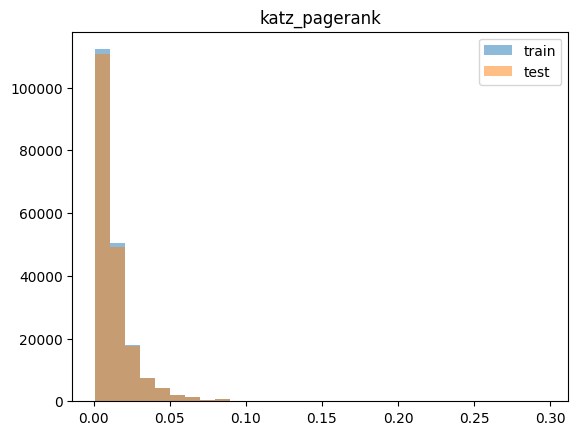

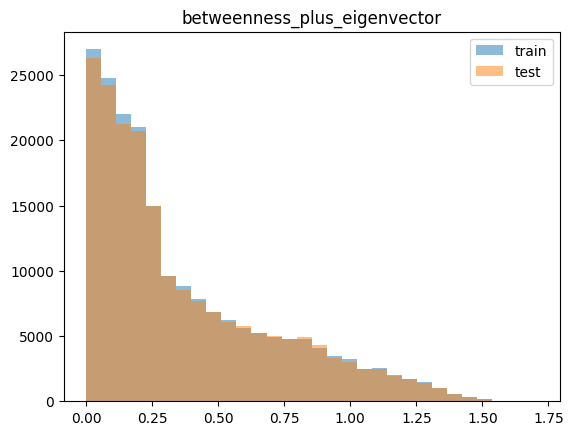

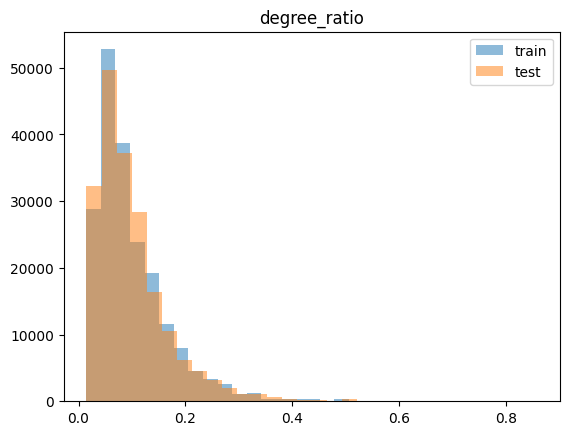

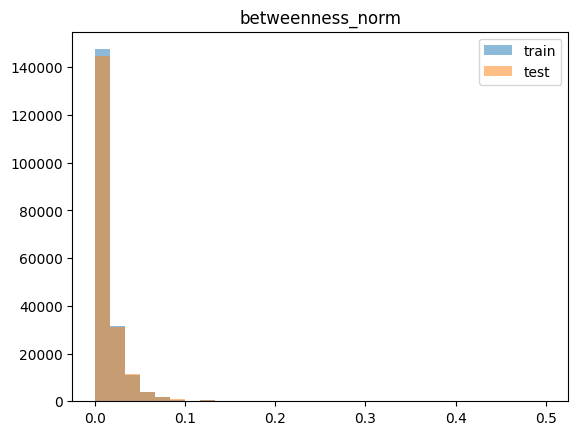

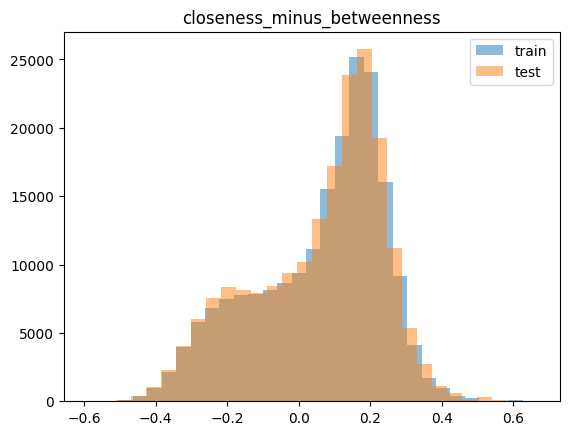

In [35]:
# Compare basic statistics between train and test
print("Train stats:")
print(df_train[features].describe())
print("\nTest stats:")
print(df_test_processed[features].describe())

# Visualize distributions (for key features)
import matplotlib.pyplot as plt
for feat in features:
    plt.figure()
    plt.hist(df_train[feat], alpha=0.5, label='train', bins=30)
    plt.hist(df_test_processed[feat], alpha=0.5, label='test', bins=30)
    plt.title(feat)
    plt.legend()
    plt.show()